<a href="https://colab.research.google.com/github/rein55/Ensemble-Learning/blob/main/Ensemble_Learning_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, mean_squared_error
import xgboost as xgb
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

## Data exploration

In [ ]:
df = pd.read_csv('loan_data.csv')

# TODO: Basic data exploration. Use df.shape and df.isnull().sum()
df.isnull().sum()

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Define features and targets

In [ ]:
target_column_name = 'loan_status'
# TODO: drop target from the dataframe. Use df.drop(target_column_name, axis=1)
X = df.drop(target_column_name, axis=1)

# TODO: use target_column_name as the target variable
y = df[target_column_name]

In [ ]:
n_negatives = y[y == 0].shape[0]

# TODO: count positive values. Use the same syntax as the one above
n_positives = y[y == 1].shape[0]

In [ ]:
n_negatives, n_positives

(35000, 10000)

## Preprocess dataset

### Define categorical and numerical features

In [ ]:
# TODO: find numeric and categorical features. Use 'int64' and 'float64' for numerical and 'object' for categorical
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [ ]:
numeric_features

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')

In [ ]:
categorical_features

Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')

### Define transformers

In [ ]:
# TODO: create numerical preprocessor using sklearn pipeline. Use imputer with
# median strategy and a minmax scaler
numerical_imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler()
numeric_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', scaler)
])


# TODO: create categorical preprocessor using sklearn pipeline. Use imputer with
# constant strategy and a Onehot encoder
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')
onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
categorical_transformer = Pipeline(steps=[
     ('imputer', categorical_imputer),
     ('onehot', onehot_encoder)
 ])

# TODO: create a preprocessor using ColumnTransformer object.
preprocessor = ColumnTransformer(
     transformers=[
         ('num', numeric_transformer, numeric_features),
         ('cat', categorical_transformer, categorical_features)
     ])

In [ ]:
# TODO: create a function create_preprocessor() to create the above preprocessor
def create_preprocessor():
     numerical_imputer = SimpleImputer(strategy='median')
     scaler = MinMaxScaler()
     numeric_transformer = Pipeline(steps=[
         ('imputer', numerical_imputer),
         ('scaler', scaler)
     ])


     categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')
     onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
     categorical_transformer = Pipeline(steps=[
         ('imputer', categorical_imputer),
         ('onehot', onehot_encoder)
     ])

     preprocessor = ColumnTransformer(
         transformers=[
             ('num', numeric_transformer, numeric_features),
             ('cat', categorical_transformer, categorical_features)
         ])

     return preprocessor

In [ ]:
preprocessor = create_preprocessor()

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])

### Split train and *test*

In [ ]:
# TODO: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
preprocessor.fit_transform(X_train)

array([[0.11290323, 0.01241039, 0.088     , ..., 1.        , 0.        ,
        0.        ],
       [0.04032258, 0.00903032, 0.024     , ..., 0.        , 1.        ,
        1.        ],
       [0.16935484, 0.04373797, 0.144     , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.10483871, 0.0069955 , 0.072     , ..., 0.        , 1.        ,
        1.        ],
       [0.0483871 , 0.02371855, 0.048     , ..., 0.        , 0.        ,
        0.        ],
       [0.0483871 , 0.02820806, 0.032     , ..., 1.        , 0.        ,
        1.        ]])

In [ ]:
preprocessor.transform(X_test)[0]

array([0.09677419, 0.01235477, 0.08      , 0.20289855, 0.04252401,
       0.12698413, 0.28571429, 0.45869565, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

## Random Forest

### Create Random Forest pipeline

https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
def predict(model, test_data, threshold = 0.5):
    return (model.predict_proba(test_data)[:, 1] >= threshold).astype(int)

In [ ]:
# TODO: create a function to create a random forest pipeline
def create_random_forest_pipeline(hyperparams):
    class_weight = {0: n_negatives, 1: n_positives}
    preprocessor = create_preprocessor()
    classifier = RandomForestClassifier(**hyperparams,
                                        class_weight=class_weight,
                                        random_state=42)
    rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
    return rf_pipeline

hyperparams = {"n_estimators": 50, "max_depth": 50, "max_features": "log2"}
rf_pipeline = create_random_forest_pipeline(hyperparams)

In [ ]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 35000, 1: 10000},
                                        max_depth=50, max_features='log2',
                                        n_estimators=50, random_state=42))])

### Train model

In [ ]:
# TODO: train the model and calculate the loss
rf_pipeline.fit(X_train, y_train)

# Estimate probability on train and test dataset
train_probs = rf_pipeline.predict_proba(X_train)
test_probs = rf_pipeline.predict_proba(X_test)

# Print train and test loss
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)
print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

Train loss: 0.04801525358554533
Test loss: 0.17553027106638408


### Plot result

Results:
Test Accuracy: 0.9107777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6990
           1       0.98      0.61      0.75      2010

    accuracy                           0.91      9000
   macro avg       0.94      0.80      0.85      9000
weighted avg       0.92      0.91      0.90      9000



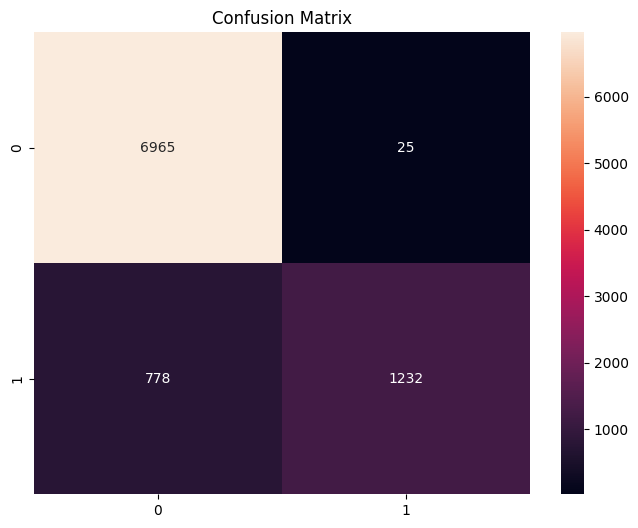

In [ ]:
# TODO: Plot results of random forest classifier
y_pred_test = predict(rf_pipeline, X_test, 0.8)
# Print metrics
print(f"Results:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()

In [ ]:
# TODO: modify the hyperparameters and threshold and see what happens

## XGBoost
https://xgboost.readthedocs.io/en/stable/parameter.html

### Predict with modified threshold

In [ ]:
# TODO: write function to create an XGBoost pipeline

def create_xgb_pipeline(hyperparams):
    preprocessor = create_preprocessor()
    classifier = xgb.XGBClassifier(**hyperparams,
                                   scale_pos_weight=n_negatives/n_positives,
                                   random_state=42)
    xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
    return xgb_pipeline

hyperparams = {"n_estimators": 50, "max_depth": 15, "subsample": 0.2, 'eta': 0.1}
xgb_pipeline = create_xgb_pipeline(hyperparams)

### Train model

In [ ]:
# TODO: train the XGBoost model and calculate the loss

xgb_pipeline.fit(X_train, y_train)

# Estimate probability on train and test dataset
train_probs = xgb_pipeline.predict_proba(X_train)
test_probs = xgb_pipeline.predict_proba(X_test)

# Print train and test loss
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)
print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

Train loss: 0.12077766454392784
Test loss: 0.18472070239803254


### Plot result

Results:
Test Accuracy: 0.9218888888888889

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6990
           1       0.91      0.72      0.81      2010

    accuracy                           0.92      9000
   macro avg       0.92      0.85      0.88      9000
weighted avg       0.92      0.92      0.92      9000



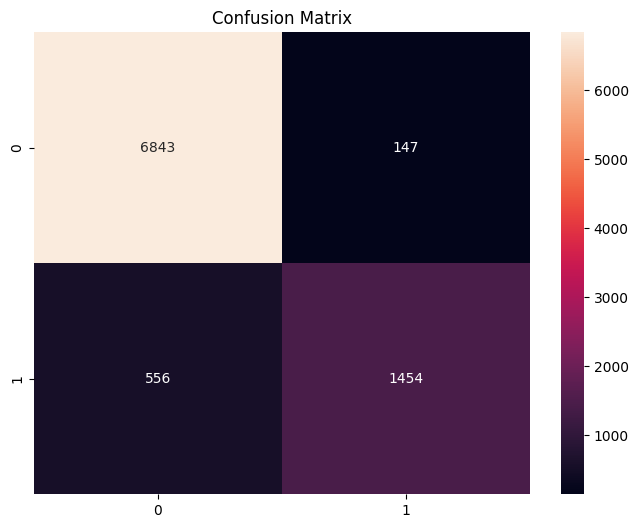

In [ ]:
# TODO: Plot results of XGBoost classifier
y_pred_test = predict(xgb_pipeline, X_test, 0.8)
# Print metrics
print(f"Results:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()

In [ ]:
# TODO: change the hyperparameters and threshold and see what happens

## Optimization of XGBoost model with Optuna

In [ ]:
def objective(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1, 5)
    }

    xgb_pipeline = create_xgb_pipeline(xgb_params)

    # Use cross-validation score as our metric
    score = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='precision').mean()
    return score

In [ ]:
# TODO: play around and run the optuna optimizer
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-09 04:53:38,469] A new study created in memory with name: no-name-4a0802e2-d462-415d-bc7a-4c62e1605c44
<ipython-input-117-fb09fab06277>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-11-09 04:53:46,765] Trial 0 finished with value: 0.6890432648518704 and parameters: {'max_depth': 3, 'learning_rate': 0.07160240823047778, 'n_estimators': 200, 'min_child_weight': 1, 'subsample': 0.6244043573832972, 'colsample_bytree': 0.8469740313661037, 'gamma': 1.4246218805637785}. Best is trial 0 with value: 0.6890432648518704.
<ipython-input-117-fb09fab06277>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True

Best trial:
  Value:  0.7494374166181457
  Params: 
    max_depth: 10
    learning_rate: 0.03752869526044983
    n_estimators: 202
    min_child_weight: 6
    subsample: 0.6277646449723883
    colsample_bytree: 0.949455679826078
    gamma: 3.6770691999596328


## Evaluate with best parameters


XGBoost Results:
Accuracy: 0.9126666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      6990
           1       0.75      0.91      0.82      2010

    accuracy                           0.91      9000
   macro avg       0.86      0.91      0.88      9000
weighted avg       0.92      0.91      0.92      9000



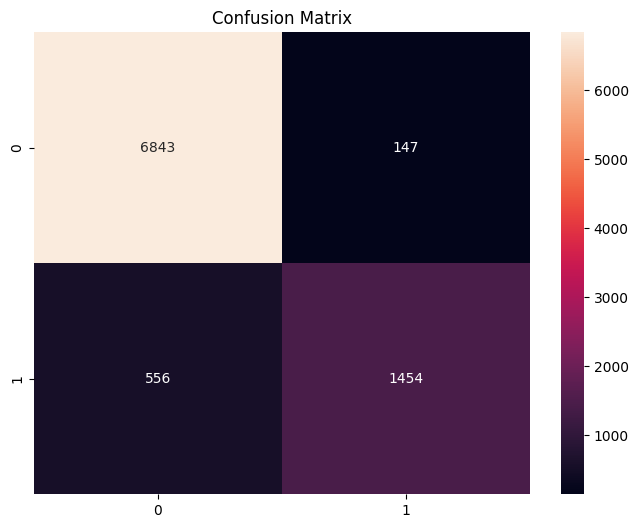

In [ ]:
# TODO: Train XGBoost with best parameters
best_params = study.best_params
xgb_model = create_xgb_pipeline(best_params)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

print("\nXGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()